# Exploratory Data Analysis

In [1]:
from bank_marketing import *

## Import Data

The first step of data preparation is to import data. We use `pandas`'s `read_csv()` to import data and take care of data types, true/false values and missing values.

In [2]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

## Exploratory Data Analysis

Exploratory Data Analysis is a process to explore the dataset with no assumptions or hypothesis. The objective is to give us enough insights for the future work.

There are many visualization libraries in Python. Pandas has its own plot API based on matplotlib and we will also use Seaborn and Altair. Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics. Altair is a declarative statistical visualization library for Python, based on Vega and Vega-Lite. Both libraries provide easy to use APIs and produce beautiful graphs.

Let's first inpect the outcome distribution. As we can see below, the dataset is imbalanced. With 41188 rows of data, only 11.2% have positive outcome.

In [3]:
bank_mkt["y"].count()

41176

In [4]:
bank_mkt["y"].sum()/bank_mkt["y"].count()

0.11266271614532737

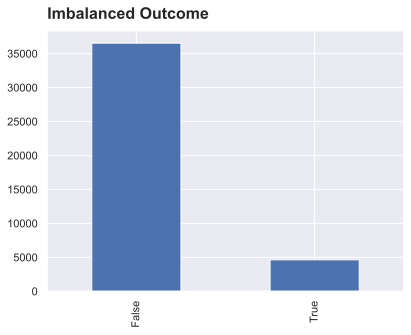

In [5]:
y_count = bank_mkt["y"].value_counts().plot(kind = "bar", title="Imbalanced Outcome")

Using `info()` we can see that most of features concerning the client are categorical/boolean type. And some fields such as `job`, `marital`, `education`, etc. are missing.

In [6]:
bank_mkt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41176 entries, 0 to 41175
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41176 non-null  Int64   
 1   job             40846 non-null  category
 2   marital         41096 non-null  category
 3   education       39446 non-null  category
 4   default         32580 non-null  boolean 
 5   housing         40186 non-null  boolean 
 6   loan            40186 non-null  boolean 
 7   contact         41176 non-null  category
 8   month           41176 non-null  Int64   
 9   day_of_week     41176 non-null  Int64   
 10  duration        41176 non-null  Int64   
 11  campaign        41176 non-null  Int64   
 12  pdays           1515 non-null   Int64   
 13  previous        41176 non-null  Int64   
 14  poutcome        5625 non-null   boolean 
 15  emp.var.rate    41176 non-null  float64 
 16  cons.price.idx  41176 non-null  float64 
 17  cons.conf.id

## Time-ordered data

In [7]:
bank_mkt["year"]=2008
bank_mkt.loc[27682:, "year"] = 2009
bank_mkt.loc[39118:, "year"] = 2010
bank_mkt["date"] = pd.to_datetime(bank_mkt[["month", "year"]].assign(day=1))

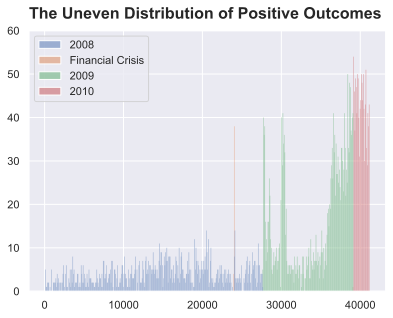

In [8]:
p = bank_mkt[bank_mkt.y == True].reset_index()
p.loc[(p.month == 10) & (p.year==2008), "year"] = "Financial Crisis"
ax = sns.histplot(data=p, x="index", stat="count", hue="year", bins=500, palette="deep", legend=True)
ax.get_legend().set_title("")
ax.set_ylim(0,60)
ax.set(title="The Uneven Distribution of Positive Outcomes", xlabel="", ylabel="");

Oct 2008 is a special case possibly due to the financial crisis.

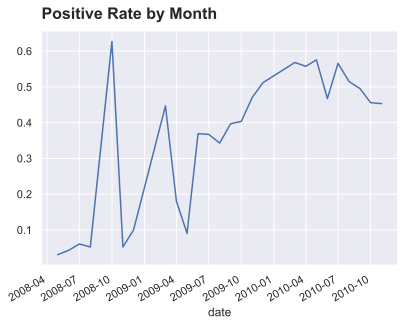

In [43]:
bank_mkt[["date", "y"]].groupby("date").mean().plot.line(ylabel="", title="Positive Rate by Month", legend=False);

### Missing values

By checking the number of missing values, we can see nearly all client do not have `pdays` and `poutcome`. 20% of the clients do not have information of `default`.

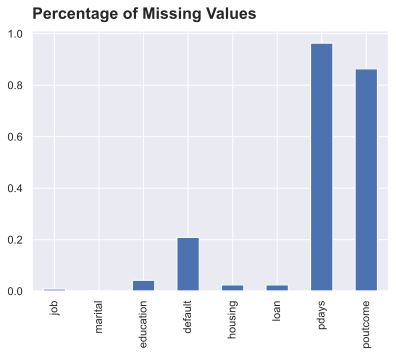

In [10]:
na = bank_mkt.isna().sum()
na_nonzero = na[na != 0]
na_perc = na_nonzero/bank_mkt.y.count()
na_bar = na_perc.plot.bar(title="Percentage of Missing Values")

### Client Data

Let's start with basic client data.

Most of the clients's age are between 32 to 47 while there are some outlier cases beyond 70. This may imply that we should choose standardization for scaling since it's more tolerant for outliers.

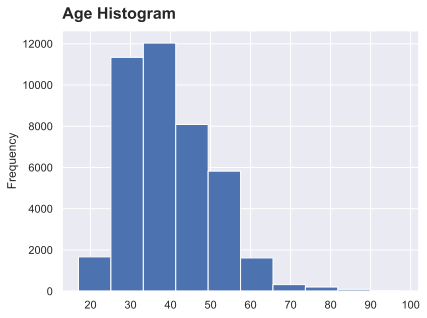

In [11]:
age_hist = bank_mkt["age"].plot.hist(title="Age Histogram")

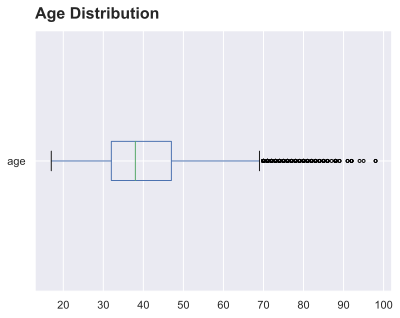

In [12]:
age_box = bank_mkt["age"].plot.box(vert=False, sym=".", title="Age Distribution")

From the graph below we can see that the age distribution in the true outcome group has lower median age but is more skewed toward an slightly older population.

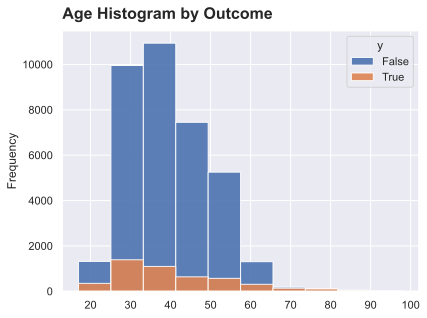

In [13]:
age_y = bank_mkt[["age", "y"]].pivot(columns="y", values="age")
age_hist_outcome = age_y.plot.hist(alpha=0.9, legend=True, title="Age Histogram by Outcome")

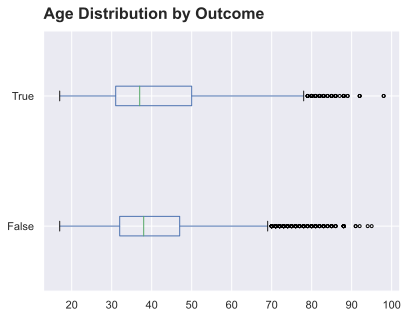

In [14]:
age_box_outcome = age_y.plot.box(vert=False, sym=".", title="Age Distribution by Outcome")

We can also inspect the relationship between age and other categorical values.

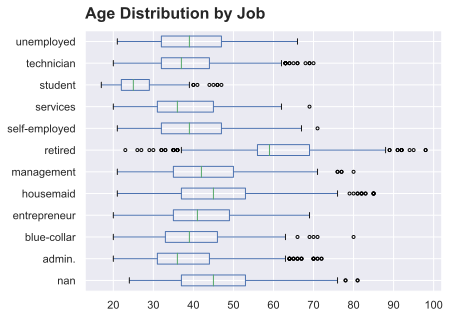

In [15]:
age_job = bank_mkt[["age", "job"]].pivot(columns="job", values="age")
age_job_box = age_job.plot.box(vert=False, sym=".", title="Age Distribution by Job")

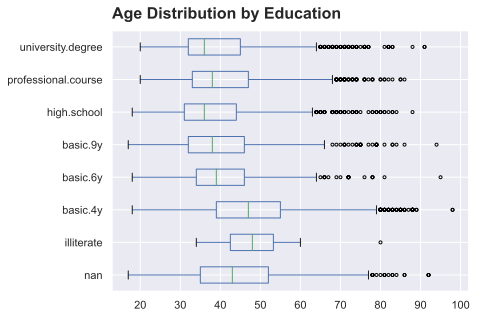

In [16]:
age_education = bank_mkt[["age", "education"]].pivot(columns="education", values="age")
age_education_box = age_education.plot.box(vert=False, sym=".", title="Age Distribution by Education")

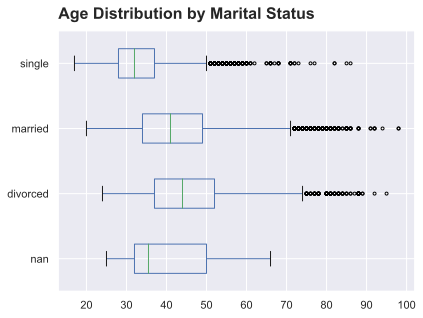

In [17]:
age_marital = bank_mkt[["age", "marital"]].pivot(columns="marital", values="age")
age_marital_box = age_marital.plot.box(vert=False, sym=".", title="Age Distribution by Marital Status")

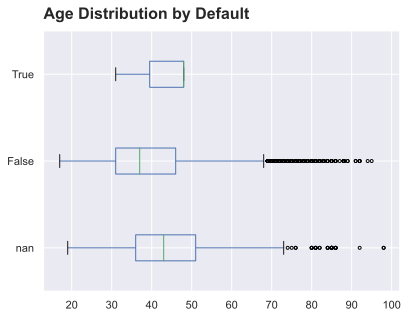

In [18]:
age_default = bank_mkt[["age", "default"]].pivot(columns="default", values="age")
age_default_box = age_default.plot.box(vert=False, sym=".", title="Age Distribution by Default")

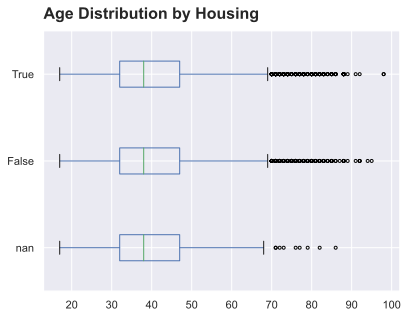

In [19]:
age_housing = bank_mkt[["age", "housing"]].pivot(columns="housing", values="age")
age_housing_box = age_housing.plot.box(vert=False, sym=".", title="Age Distribution by Housing")

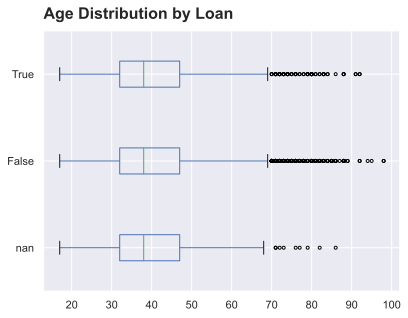

In [20]:
age_loan = bank_mkt[["age", "loan"]].pivot(columns="loan", values="age")
age_loan_box = age_loan.plot.box(vert=False, sym=".", title="Age Distribution by Loan")

We can then turn to job, eductaion and other categorical data to see their relationship to the outcome.

In [21]:
def explore_cat(df, feature):
    df = df.copy()
    if pd.api.types.is_categorical_dtype(df[feature]):
        df[feature] = df[feature].cat.add_categories('unknown')
        df[feature] = df[feature].fillna("unknown")
    feature_true = df[[feature, "y"]].groupby([feature]).sum().y.rename("True")
    feature_total = df[[feature, "y"]].groupby([feature]).count().y.rename("Total")
    feature_false = feature_total - feature_true
    feature_false = feature_false.rename("False")
    feature_true_rate = feature_true / feature_total
    feature_true_rate = feature_true_rate.rename("True Percentage")
    explore_df = pd.concat([feature_true, feature_false, feature_total, feature_true_rate], axis=1).reset_index()
    return explore_df

In [22]:
def cat_outcome(df, feature):
    df = df.copy()
    if pd.api.types.is_categorical_dtype(df[feature]) and df[feature].isna().sum() > 0:
        df[feature] = df[feature].cat.add_categories("unknown")
        df[feature] = df[feature].fillna("unknown")
    title = feature.title().replace("_", " ").replace("Of", "of")
    f, axs = plt.subplots(1, 2, figsize=(8.6, 4.8), sharey=True, gridspec_kw=dict(wspace=0.04, width_ratios=[5, 2]))
    ax0 = df["y"].groupby(df[feature], dropna=False).value_counts(normalize=True).unstack().plot.barh(xlabel="", legend=False, stacked=True, ax=axs[0], title=f"Outcome Percentage and Total by {title}")
    ax1 = df["y"].groupby(df[feature], dropna=False).value_counts().unstack().plot.barh(xlabel="", legend=False, stacked=True, ax=axs[1])

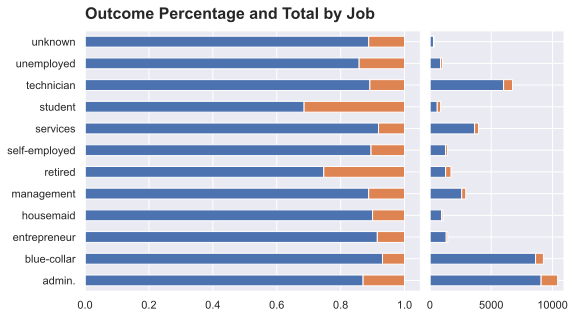

In [23]:
job_outcome = cat_outcome(bank_mkt, "job")

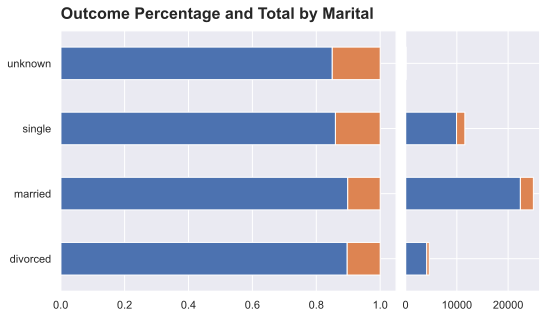

In [24]:
marital_outcome = cat_outcome(bank_mkt, "marital")

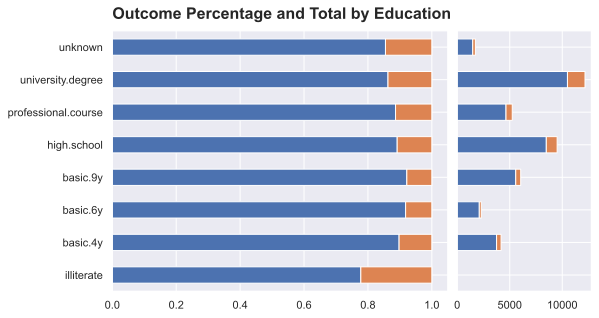

In [25]:
education_outcome = cat_outcome(bank_mkt, "education")

In [26]:
bank_mkt["default"].value_counts()

False    32577
True         3
Name: default, dtype: Int64

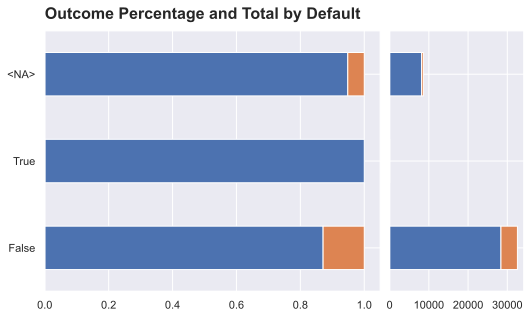

In [27]:
default_outcome = cat_outcome(bank_mkt, "default")

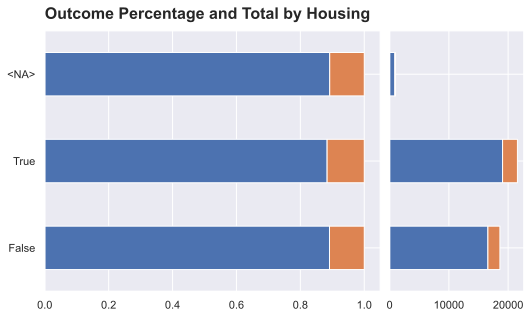

In [28]:
housing_outcome = cat_outcome(bank_mkt, "housing")

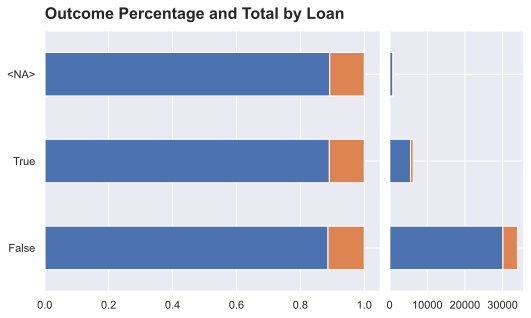

In [29]:
loan_outcome = cat_outcome(bank_mkt, "loan")

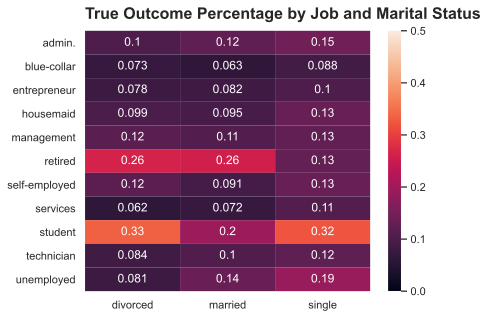

In [30]:
job_marital_total = bank_mkt[["job", "marital", "y"]].groupby(["job", "marital"]).count().y.unstack()
job_marital_true = bank_mkt[["job", "marital", "y"]].groupby(["job", "marital"]).sum().y.unstack()
job_marital_rate = job_marital_true / job_marital_total
job_marital_rate = job_marital_rate.rename_axis(None, axis=0).rename_axis(None, axis=1)
job_marital_heatmap = sns.heatmap(data=job_marital_rate, vmin=0, vmax=0.5, annot=True).set_title("True Outcome Percentage by Job and Marital Status")

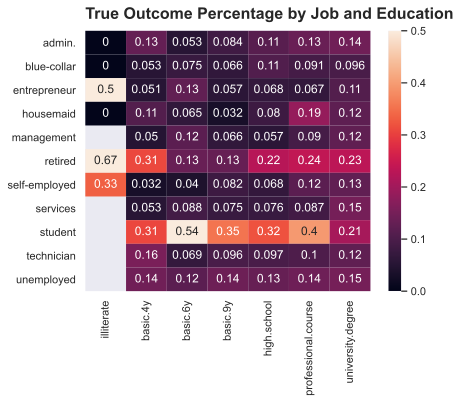

In [31]:
job_education_total = bank_mkt[["job", "education", "y"]].groupby(["job", "education"]).count().y.unstack()
job_education_true = bank_mkt[["job", "education", "y"]].groupby(["job", "education"]).sum().y.unstack()
job_education_rate = job_education_true / job_education_total
job_education_rate = job_education_rate.rename_axis(None, axis=0).rename_axis(None, axis=1)
job_education_heatmap = sns.heatmap(data=job_education_rate, vmin=0, vmax=0.5, annot=True).set_title("True Outcome Percentage by Job and Education")

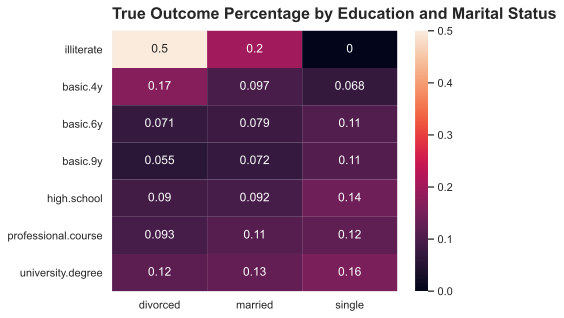

In [32]:
education_marital_total = bank_mkt[["education", "marital", "y"]].groupby(["education", "marital"]).count().y.unstack()
education_marital_true = bank_mkt[["education", "marital", "y"]].groupby(["education", "marital"]).sum().y.unstack()
education_marital_rate = education_marital_true / education_marital_total
education_marital_rate = education_marital_rate.rename_axis(None, axis=0).rename_axis(None, axis=1)
education_marital_heatmap = sns.heatmap(data=education_marital_rate, vmin=0, vmax=0.5, annot=True).set_title("True Outcome Percentage by Education and Marital Status")

### Current Campaign

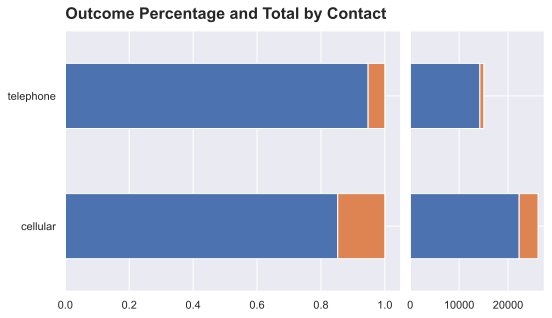

In [33]:
contact_outcome = cat_outcome(bank_mkt, "contact")

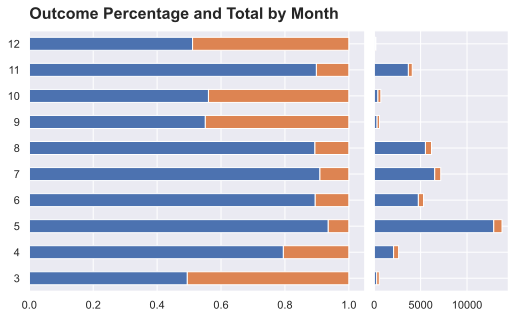

In [34]:
month_outcome = cat_outcome(bank_mkt, "month")

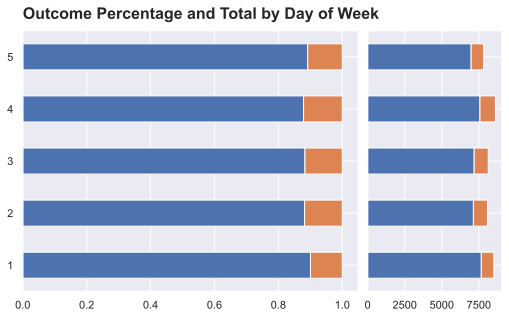

In [35]:
day_outcome = cat_outcome(bank_mkt, "day_of_week")

### Previous Campaign

We can plot the dirstribution of `pdays` and `previous`. As we can see, most of the client with `pdays` has been contacted 3 to 6 days before and peaked at 3 and 6 days.

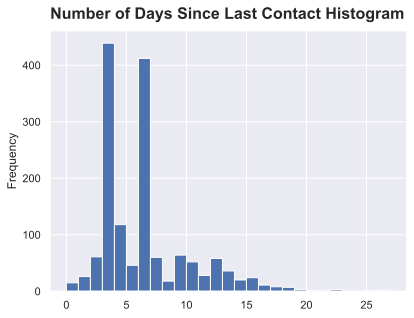

In [36]:
pdays_hist = bank_mkt["pdays"].plot.hist(bins=27, title="Number of Days Since Last Contact Histogram")

Most of the client has never been contacted before.

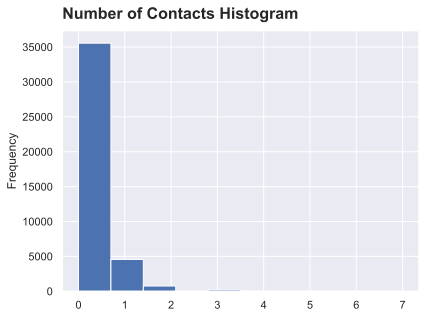

In [37]:
previous_hist = bank_mkt["previous"].plot.hist(title="Number of Contacts Histogram")

If `pdays` is missing value, that means that the client was not previously contacted and therefore should not have `poutcome`. But `poutcome` column has less missing values than `pdays`. 

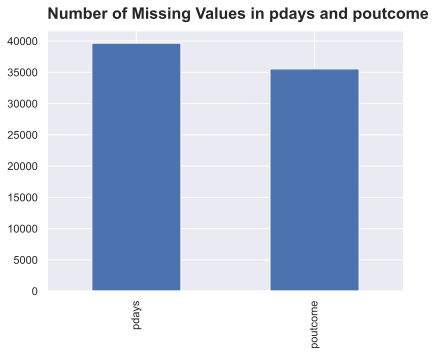

In [38]:
previous_na = bank_mkt[["pdays", "poutcome"]].isna().sum()
previous_na_ax = previous_na.plot.bar(title="Number of Missing Values in pdays and poutcome")

We can print out the 4110 rows where the client is not contacted but have `poutcome` and see how many times they have been contacted before. The figures suggest that maybe these clients has been actually contacted but it was more than 30 days ago so the contact date was not recorded. This leaves us plenty room for feature engineering.

In [39]:
previous = bank_mkt[["campaign", "pdays", "previous", "poutcome", "y"]]
previous = previous[previous["pdays"].isna() & previous["poutcome"].notna()].reset_index(drop=True)
previous

,campaign,pdays,previous,poutcome,y
0,1,<NA>,1,False,False
1,1,<NA>,1,False,True
2,1,<NA>,1,False,False
3,1,<NA>,1,False,True
4,1,<NA>,1,False,False
...,...,...,...,...,...
4105,1,<NA>,1,False,True
4106,2,<NA>,4,False,False
4107,1,<NA>,2,False,True
4108,1,<NA>,2,False,False


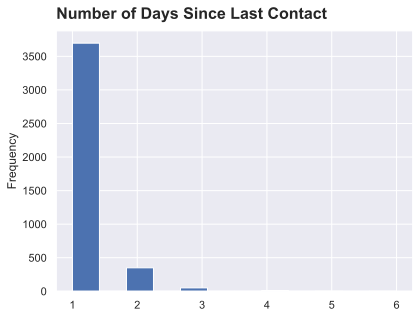

In [46]:
previous_ax = previous["previous"].plot.hist(bins=12, title="Number of Days Since Last Contact")

In [41]:
bank_mkt[bank_mkt["pdays"].isna() & bank_mkt["poutcome"].isna()]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,year,date
0,56,housemaid,married,basic.4y,False,False,False,telephone,5,1,261,1,<NA>,0,<NA>,1.1,93.994,-36.4,4.857,5191.0,False,2008,2008-05-01
1,57,services,married,high.school,<NA>,False,False,telephone,5,1,149,1,<NA>,0,<NA>,1.1,93.994,-36.4,4.857,5191.0,False,2008,2008-05-01
2,37,services,married,high.school,False,True,False,telephone,5,1,226,1,<NA>,0,<NA>,1.1,93.994,-36.4,4.857,5191.0,False,2008,2008-05-01
3,40,admin.,married,basic.6y,False,False,False,telephone,5,1,151,1,<NA>,0,<NA>,1.1,93.994,-36.4,4.857,5191.0,False,2008,2008-05-01
4,56,services,married,high.school,False,False,True,telephone,5,1,307,1,<NA>,0,<NA>,1.1,93.994,-36.4,4.857,5191.0,False,2008,2008-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41169,37,admin.,married,university.degree,False,True,False,cellular,11,5,281,1,<NA>,0,<NA>,-1.1,94.767,-50.8,1.028,4963.6,True,2010,2010-11-01
41171,73,retired,married,professional.course,False,True,False,cellular,11,5,334,1,<NA>,0,<NA>,-1.1,94.767,-50.8,1.028,4963.6,True,2010,2010-11-01
41172,46,blue-collar,married,professional.course,False,False,False,cellular,11,5,383,1,<NA>,0,<NA>,-1.1,94.767,-50.8,1.028,4963.6,False,2010,2010-11-01
41173,56,retired,married,university.degree,False,True,False,cellular,11,5,189,2,<NA>,0,<NA>,-1.1,94.767,-50.8,1.028,4963.6,False,2010,2010-11-01


### Correlation Heatmap

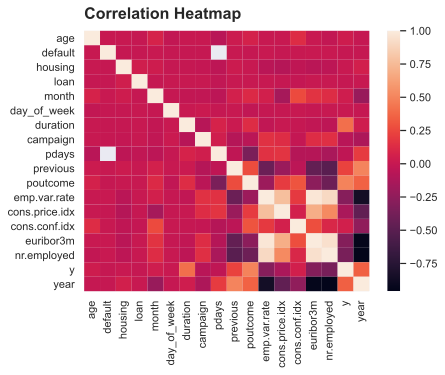

In [42]:
corr_heatmap = sns.heatmap(data=bank_mkt.corr(method="pearson")).set_title("Correlation Heatmap")